# Вебинар 6. Двухуровневые модели рекомендаций

Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

# # Написанные нами функции
from src.metrics import precision_at_k, recall_at_k, ndcg_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, items=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\Diana\Documents\Recsys\6\src\utils.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cost'] = data['sales_value'] / data['quantity']


Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1, weighting='bm25', fake_id=999999)

C:\Users\Diana\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [5]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [6]:
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
result_lvl_1['s_it'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_lvl_1['s_us'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [7]:
print('Own: {}'.format(result_lvl_1.apply(lambda row: recall_at_k(row['own'], row['actual'], k=50), axis=1).mean()))
print('Als: {}'.format(result_lvl_1.apply(lambda row: recall_at_k(row['als'], row['actual'], k=50), axis=1).mean()))
print('Similar items: {}'.format(result_lvl_1.apply(lambda row: recall_at_k(row['s_it'], row['actual'], k=50), axis=1).mean()))
print('Similar users: {}'.format(result_lvl_1.apply(lambda row: recall_at_k(row['s_us'], row['actual'], k=50), axis=1).mean()))

Own: 0.116519185097596
Als: 0.0613379357483387
Similar items: 0.04407350295115321
Similar users: 0.04009597324851246


A) Own recommendations + top popular при использовании взвешивания bm25 дают лучший recall.

[0.0753652064894047, 0.116519185097596, 0.1582039364268389, 0.2060267225704268, 0.26834283077056215]


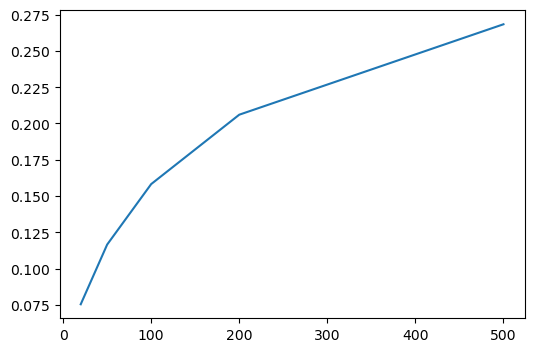

In [8]:
k_range = [20, 50, 100, 200, 500]
recall = []

for k in k_range:
    result_lvl_1['candidates'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
    recall.append(result_lvl_1.apply(lambda row: recall_at_k(row['candidates'], row['actual'], k=k), axis=1).mean())

print(recall)
plt.figure(figsize=(6, 4))
plt.plot(k_range, recall)
plt.show()

B) Чем больше кандидатов (k), тем больше тех items, которые пользователю могут понравиться, и больше recall.

C) Чтобы не было очень долгого процесса подбора рекомендаций, можно выбрать оптимальный k, равный 100-200.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [9]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique()) # пользователи из 2 части (6 недель)
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique() # пользователи из 1 части
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)] # пользователи из 1 части, которые есть во 2

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(
    lambda x: recommender.get_own_recommendations(x, N=100))

users_lvl_2.head()

,user_id,candidates
0,2070,"[1085604, 834103, 1119399, 917033, 879755, 936..."
1,2021,"[922561, 950935, 1119454, 1013928, 1019142, 86..."
2,1753,"[879755, 986912, 1089066, 901543, 1085604, 103..."
3,2120,"[1106523, 1133018, 951590, 908531, 961554, 556..."
4,1346,"[5574377, 903738, 5568758, 1082212, 866211, 89..."


---------------------

In [10]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

result_lvl_2 = result_lvl_2.merge(users_lvl_2, on='user_id', how='inner')
result_lvl_2.head(3)

,user_id,actual,candidates
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 5577022, 9655212, 940947, 9527290, 10..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1119051, 13003092, 1037863, 8203834, 863447, ..."
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1122358, 922561, 6602729, 12731436, 1079023, ..."


In [11]:
result_lvl_2.apply(lambda row: precision_at_k(row['candidates'], row['actual'], k=5), axis=1).mean()

0.2663185378590054

-------------------------

In [12]:
# Для каждого рекоммендованного item - своя пара с user из 1 части
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,1085604,1
0,2070,834103,1
0,2070,1119399,1
0,2070,917033,1


In [13]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,1085604,1.0
1,2070,834103,1.0


In [14]:
targets_lvl_2['target'].mean()

0.13658521384148975

In [15]:
def generate_fs(data, item_features, user_features):
    data.sort_values(['week_no', 'day', 'trans_time'], inplace=True)
    data.reset_index(drop=True, inplace=True)

    # Цена (value)
    data['value'] = (data['sales_value'] - data['retail_disc']) / data['quantity']
    np.nan_to_num(data['value'], copy=False, nan=0.0, posinf=0.0, neginf=0.0)

    # средняя цена в категории (value_cat_mean)
    data = data.merge(item_features, on='item_id', how='left')
    data = data.merge(data.groupby('department')['value'].mean(), on='department', 
                      how='left', suffixes=(None, '_cat_mean'))
    
    # среднее количество покупок 1 товара в категории в неделю (mean_pw)
    hd = data.groupby(['department', 'week_no'])['quantity'].mean().reset_index()\
                        .rename(columns={'quantity': 'mean_pw'})
    data = data.merge(hd, on=['department', 'week_no'], how='left')
    
    # Средний чек (mean_check)
    hd = data.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()\
                        .rename(columns={'sales_value': 'mean_check'})
    hd = hd.groupby('user_id')['mean_check'].mean()
    data = data.merge(hd, on='user_id', how='inner')

    # Доля покупок в каждой категории (us_cat_q)
    hd = (data.groupby(['user_id', 'department'])['quantity'].sum() / \
                        data.groupby('user_id')['quantity'].sum()).reset_index()\
                        .rename(columns={'quantity': 'us_cat_q'})
    data = data.merge(hd, on=['user_id', 'department'], how='left')
    
    # Долю покупок утром/днем/вечером (daytime_quant)
    data['daytime'] = np.nan
    data.loc[data['trans_time'] < 600, 'daytime'] = 'N'
    data.loc[(data['trans_time'] >= 600) & (data['trans_time'] < 1200), 'daytime'] = 'M'
    data.loc[(data['trans_time'] >= 1200) & (data['trans_time'] < 1800), 'daytime'] = 'D'
    data.loc[data['trans_time'] >= 1800, 'daytime'] = 'E'

    hd = (data.groupby(['user_id', 'daytime'])['quantity'].sum() / \
        data.groupby(['user_id'])['quantity'].sum()).reset_index()\
                        .rename(columns={'quantity': 'daytime_quant'})
    data = data.merge(hd, on=['user_id', 'daytime'], how='left')
    
    # Частотность покупок раз/месяц (cnt_pm)
    m = 1
    month = []
    for d in data['day'].unique():
        if (d - (m-1)*30.417)/30.417 > 1:
            m += 1
        month.append(m)

    hd = pd.DataFrame(data['day'].unique(), columns=['day'])
    hd['month'] = month
    data = data.merge(hd, on='day', how='inner')
    
    hd = data.groupby(['user_id', 'month'])['basket_id'].count().reset_index()\
                .rename(columns={'basket_id': 'cnt_pm'})
    data = data.merge(hd, on=['user_id', 'month'], how='left')
    
    # Самая часто покупаемая категория (pop_cat)
    hd = data.groupby(['user_id', 'department'])['quantity'].sum().reset_index()\
                        .rename(columns={'quantity': 'cnt'})
    data = data.merge(hd, on=['user_id', 'department'], how='left')

    data = data.merge(data.groupby('user_id')['cnt'].max(), on='user_id', how='left', 
               suffixes=(None, '_max'))

    data['pop_cat'] = np.nan
    data.loc[data['cnt_max'] == data['cnt'], 'pop_cat'] = data.loc[data['cnt_max'] == data['cnt'], 'department']
    data['pop_cat'] = data.groupby('user_id')['pop_cat'].fillna(method='ffill')
    
    # Кол-во покупок юзером конкретной категории в неделю ('us_cat_quan_pw')
    hd = data.groupby(['user_id', 'department', 'week_no'])['quantity'].sum()\
                .reset_index().rename(columns={'quantity': 'us_cat_quan_pw'})
    data = data.merge(hd, on=['user_id', 'department', 'week_no'], how='left')
    
    # Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    hd = data.groupby(['user_id', 'department'])['value'].mean().reset_index()\
                        .rename(columns={'value': 'value_pcat'})
    data = data.merge(hd, on=['user_id', 'department'], how='left')

    data = data.merge(user_features, on='user_id', how='left')
    
    # Доля покупок в каждой категории среди разных возрастных групп (age_cat_q)
    hd = (data.groupby(['age_desc', 'department'])['quantity'].sum() / \
        data.groupby('age_desc')['quantity'].sum()).reset_index()\
                        .rename(columns={'quantity': 'age_cat_q'})
    data = data.merge(hd, on=['age_desc', 'department'], how='left')
    
    # Доля покупок в каждой категории среди разных групп дохода (income_cat_q)
    hd = (data.groupby(['income_desc', 'department'])['quantity'].sum() / \
        data.groupby('income_desc')['quantity'].sum()).reset_index()\
                        .rename(columns={'quantity': 'income_cat_q'})
    data = data.merge(hd, on=['income_desc', 'department'], how='left')

    # Доля покупок в каждой категории среди разных групп, имеющих детей или нет (kid_cat_q)
    hd = (data.groupby(['kid_category_desc', 'department'])['quantity'].sum() / \
        data.groupby('kid_category_desc')['quantity'].sum()).reset_index()\
                        .rename(columns={'quantity': 'kid_cat_q'})
    data = data.merge(hd, on=['kid_category_desc', 'department'], how='left')
    
    # Средняя сумма покупки 1 товара в каждой категории среди разных возрастных груп (age_val_pcat)
    hd = data.groupby(['age_desc', 'department'])['value'].mean().reset_index()\
                        .rename(columns={'value': 'age_val_pcat'})
    data = data.merge(hd, on=['age_desc', 'department'], how='left')
    
    # Средняя сумма покупки 1 товара в каждой категории среди разных групп дохода (income_val_pcat)
    hd = data.groupby(['income_desc', 'department'])['value'].mean().reset_index()\
                        .rename(columns={'value': 'income_val_pcat'})
    data = data.merge(hd, on=['income_desc', 'department'], how='left')
    
    # Средняя сумма покупки 1 товара в каждой категории среди разных групп, имеющих детей или нет (kid_val_pcat)
    hd = data.groupby(['kid_category_desc', 'department'])['value'].mean().reset_index()\
                        .rename(columns={'value': 'kid_val_pcat'})
    data = data.merge(hd, on=['kid_category_desc', 'department'], how='left')
    
    data.drop(['cnt', 'cnt_max'], axis=1, inplace=True)
    
    return data

In [16]:
data_train_lvl_2 = generate_fs(data_train_lvl_2, item_features, user_features)
data_train_lvl_2

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,age_cat_q,income_cat_q,kid_cat_q,age_val_pcat,income_val_pcat,kid_val_pcat
0,1753,40618809138,594,1022537,1,1.39,345,0.00,8,86,...,Homeowner,Unknown,1,None/Unknown,0.001143,0.001163,0.001113,3.808629,3.778206,3.836401
1,1753,40618809138,594,1128422,1,1.45,345,-0.14,8,86,...,Homeowner,Unknown,1,None/Unknown,0.001143,0.001163,0.001113,3.808629,3.778206,3.836401
2,1753,40618809138,594,6773055,1,29.99,345,0.00,8,86,...,Homeowner,Unknown,1,None/Unknown,0.001143,0.001163,0.001113,3.808629,3.778206,3.836401
3,1753,40618809138,594,10285106,1,1.00,345,-0.49,8,86,...,Homeowner,Unknown,1,None/Unknown,0.001143,0.001163,0.001113,3.808629,3.778206,3.836401
4,1753,40618809138,594,17105257,1,1.00,345,-0.49,8,86,...,Homeowner,Unknown,1,None/Unknown,0.001143,0.001163,0.001113,3.808629,3.778206,3.836401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169706,1257,41260156777,635,13511916,1,0.89,309,0.00,1655,91,...,Homeowner,2 Adults Kids,3,1,0.006802,0.006555,0.009400,2.503938,2.510717,2.494477
169707,1784,41260412740,635,960503,1,5.59,404,-2.40,1810,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169708,1784,41260412740,635,962568,1,1.89,404,0.00,1810,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169709,1784,41260412740,635,979707,1,1.65,404,0.00,1810,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
targets_lvl_2 = targets_lvl_2.merge(data_train_lvl_2, on=['user_id', 'item_id'], how='left')

In [18]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [19]:
cat_feats = ['manufacturer', 'department', 'brand', 'commodity_desc', 'sub_commodity_desc', 
             'curr_size_of_product', 'age_desc', 'marital_status_code', 'income_desc', 
             'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
            'daytime', 'pop_cat']
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [20]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

C:\Users\Diana\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Diana\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Diana\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [21]:
X_train['proba'] = lgb.predict_proba(X_train)[:, 1]

In [22]:
res = pd.DataFrame(targets_lvl_2[targets_lvl_2['target'] == 1]\
                   .groupby('user_id')['item_id'].unique())\
                    .rename(columns={'item_id': 'actual'})

res['items'] = X_train.groupby('user_id')['item_id'].agg(lambda x: [x.values])
res['proba'] = X_train.groupby('user_id')['proba'].agg(lambda x: [x.values.argsort()[::-1]])
res['pred'] = res.apply(lambda row: 
                              pd.Series(row['items'][0][row['proba'][0]].flatten()).unique(), axis=1)
res = res.reset_index()
res

,user_id,actual,items,proba,pred
0,1,"[856942, 5577022, 9655212, 940947, 1082269, 93...","[[856942, 856942, 856942, 856942, 5577022, 965...","[[0, 12, 13, 14, 15, 16, 88, 17, 19, 20, 78, 7...","[856942, 940947, 1069575, 1082269, 931136, 865..."
1,2,"[1133018, 1106523, 1053690, 901062, 1035843, 8...","[[1075368, 911974, 8090521, 922561, 1040807, 5...","[[59, 40, 36, 33, 19, 24, 7, 89, 81, 28, 61, 1...","[12263788, 916122, 1108168, 885023, 1053690, 9..."
2,4,"[891423, 883932, 962229, 908283]","[[891423, 1075368, 910109, 883932, 883932, 883...","[[0, 29, 3, 4, 5, 6, 7, 57, 10, 88, 59, 14, 87...","[891423, 908283, 883932, 962229, 1137885, 1137..."
3,6,"[1119051, 1037863, 895268, 1098844, 845208, 10...","[[1119051, 1119051, 1119051, 1119051, 1119051,...","[[0, 22, 38, 37, 36, 86, 35, 34, 92, 93, 94, 9...","[1119051, 1037863, 1098844, 962568, 895268, 65..."
4,7,"[1122358, 1079023, 1110572, 1106523, 1126899, ...","[[1122358, 922561, 6602729, 12731436, 1079023,...","[[0, 4, 28, 24, 94, 61, 15, 12, 39, 60, 8, 36,...","[1122358, 1079023, 1072483, 1126899, 1133018, ..."
...,...,...,...,...,...
1918,2496,"[1056509, 7441210, 995876, 5569230, 995965, 82...","[[1056509, 1056509, 1056509, 1056509, 7441210,...","[[114, 23, 62, 59, 58, 56, 46, 45, 41, 40, 34,...","[1110572, 916122, 999858, 1041796, 1127624, 10..."
1919,2497,"[1135834, 870515, 900802, 897125, 1048462, 559...","[[1135834, 1031864, 916990, 870515, 8090532, 8...","[[0, 24, 54, 44, 78, 37, 36, 26, 86, 94, 14, 1...","[1135834, 5590613, 1118533, 1040807, 9836195, ..."
1920,2498,"[1070820, 1100379, 1053690, 961554, 855325, 11...","[[1126899, 1070820, 1070820, 1070820, 1070820,...","[[77, 3, 80, 65, 79, 6, 5, 94, 4, 2, 78, 1, 33...","[1106523, 1070820, 855325, 1053690, 1100379, 1..."
1921,2499,"[1070820, 947798, 833458, 944466, 5569327, 866...","[[1070820, 1070820, 1070820, 1070820, 1085604,...","[[0, 34, 58, 110, 44, 43, 42, 41, 38, 37, 36, ...","[1070820, 1060872, 853354, 1059902, 5568378, 8..."


In [23]:
res_test = res[['user_id', 'pred']]

result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

res_test = res_test.merge(result_lvl_2, on='user_id', how='inner')
res_test.head(3)

,user_id,pred,actual
0,1,"[856942, 940947, 1069575, 1082269, 931136, 865...","[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[1119051, 1037863, 1098844, 962568, 895268, 65...","[920308, 926804, 946489, 1006718, 1017061, 107..."
2,7,"[1122358, 1079023, 1072483, 1126899, 1133018, ...","[840386, 889774, 898068, 909714, 929067, 95347..."


In [24]:
res_test.apply(lambda row: precision_at_k(row['pred'], row['actual'], k=5), axis=1).mean()

0.2884439359267714

Precision@5 при использовании двухуровневой модели немного вырос.